# Driftscan FFI analysis -- `astrometry.net` WCS comparison and simulated driftscan image

Michael Gully-Santiago  
June 28, 2018

The goal of this notebook is to find out where Kepler was pointing during the driftscans, and then overlay Gaia DR2 sources on the updated field.

In [1]:
import numpy as np
import sep
import pandas as pd

In [2]:
# additional setup for reading the test image and displaying plots
import fitsio
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

We'll add some custom tools:

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../code/"))
import ffi_tools

I have the data saved locally for now.  Kepler channels have four distinct orientations on the sky (separated by 90$^\circ$ rotations from each other.  For example, in [FFI images](https://keplerscience.arc.nasa.gov/images/release-notes/c6/spica.png) you can see that certain saturated stars have their bleed columns pointing in orthogonal directions-- some go up, and some go down.  Some are also "upside down" relative to others.


For simplicity let's just focus on channels possessing the same orientation.  Thankfully, Christina Hedges identified these already!

In [4]:
ch_set_I = np.array([13,33,53,37,57,41,27,31,47,51,71])
ch = ch_set_I[2]

In [5]:
#! ls -1 ../data/C17_driftscans/ffi-kacr2120/kplr*.fits

In [6]:
dffis = ['../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131032646_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131041344_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131094047_ffi-orig.fits',
    '../data/C17_driftscans/ffi-kacr2120/kplr2018131130639_ffi-orig.fits']

## Object detection

We will need a kernel for object detection.

In [7]:
from astropy.io import fits

In [8]:
ch = 37
dffi_num = 0
hdu = fits.open('../data/reverse_engineered/ch{:02d}_ffi{:02d}_rev_eng.fits'.format(ch, dffi_num))

In [9]:
hdu[0].data

array([[-0., -0., -0., ...,  0., -0., -0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.]])

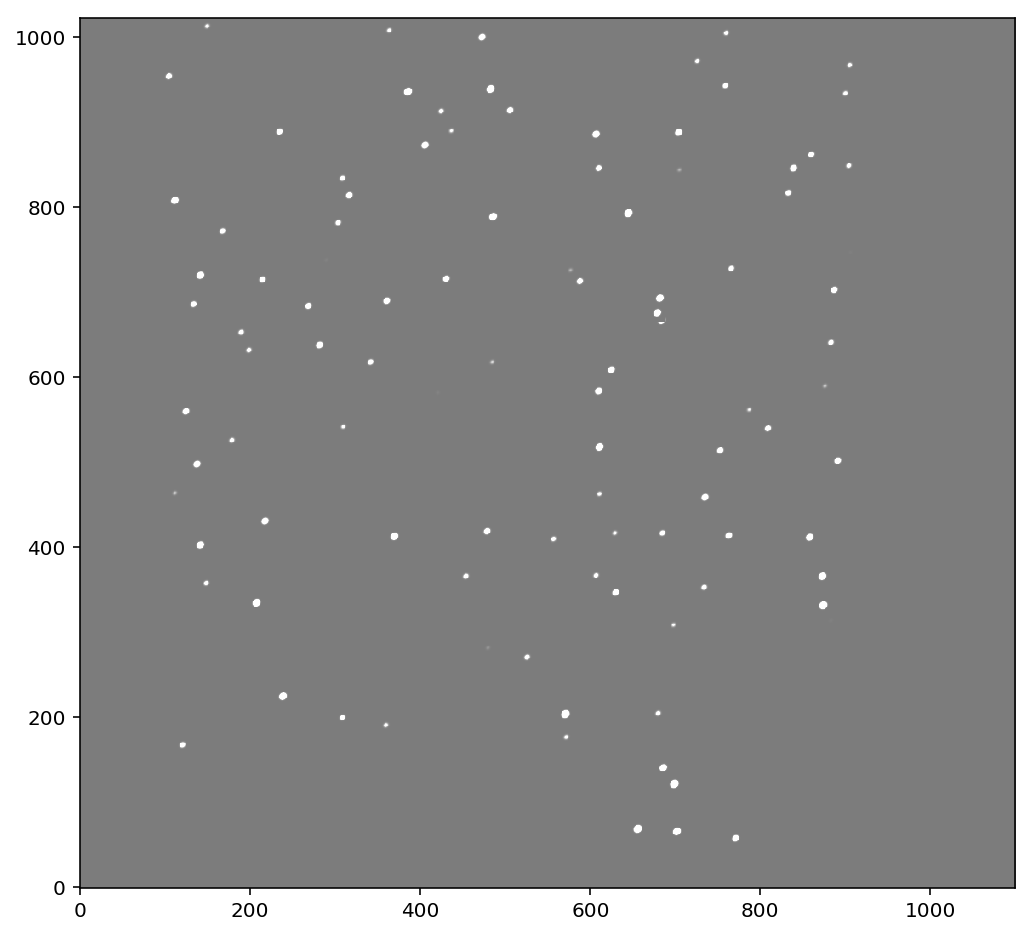

In [10]:
m, s = np.mean(hdu[0].data), np.std(hdu[0].data)
plt.imshow(hdu[0].data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

Nice, now let's try to add the WCS solution to this image.

In [11]:
#! ls ../data/reverse_engineered/wcs/

In [12]:
! mv ../data/reverse_engineered/wcs/new-image.fits ../data/reverse_engineered/wcs/ch37_dffi00_new.fits

mv: ../data/reverse_engineered/wcs/new-image.fits: No such file or directory


In [13]:
wcs_hdu = fits.open('../data/reverse_engineered/wcs/ch37_dffi00_wcs.fits')
new_hdu = fits.open('../data/reverse_engineered/wcs/ch37_dffi00_new.fits')

In [14]:
new_hdu.info()

Filename: ../data/reverse_engineered/wcs/ch37_dffi00_new.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     202   (1100, 1023)   float64   


In [15]:
new_hdu[0].data

array([[-0., -0., -0., ...,  0., -0., -0.],
       [-0., -0., -0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.]])

In [16]:
#new_hdu[0].header

In [17]:
from astropy.wcs import WCS

In [18]:
w = WCS(header=new_hdu[0].header)
# w = WCS(header=wcs_hdu[0].header)
## TODO: Try wcs_hdu since it is more "lightweight"

Great, we have a fits file with a functioning WCS header.  

In [19]:
from astroquery.vizier import Vizier
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import SkyCoord

In [20]:
Vizier.ROW_LIMIT = 50000

In [21]:
# Center of image from Astrometry.net
c1 = SkyCoord('21 26 16.196 67 23 21.989', unit=(u.hourangle, u.deg))

# Query Gaia DR2, reshape the data
result = Vizier.query_region(c1, catalog=["I/345/gaia2"], radius=Angle(3000, "arcsec"))["I/345/gaia2"]
bright_mask = (result['Gmag'] < 15.0).data
result = result[bright_mask]
radecs = np.vstack([result['RA_ICRS'].data.data, result['DE_ICRS'].data.data]).T


# Predict the (x,y) CCD positions the Gaia sources should possess
coords = w.all_world2pix(radecs, 0) ## TODO, is this supposed to be zero or one?????

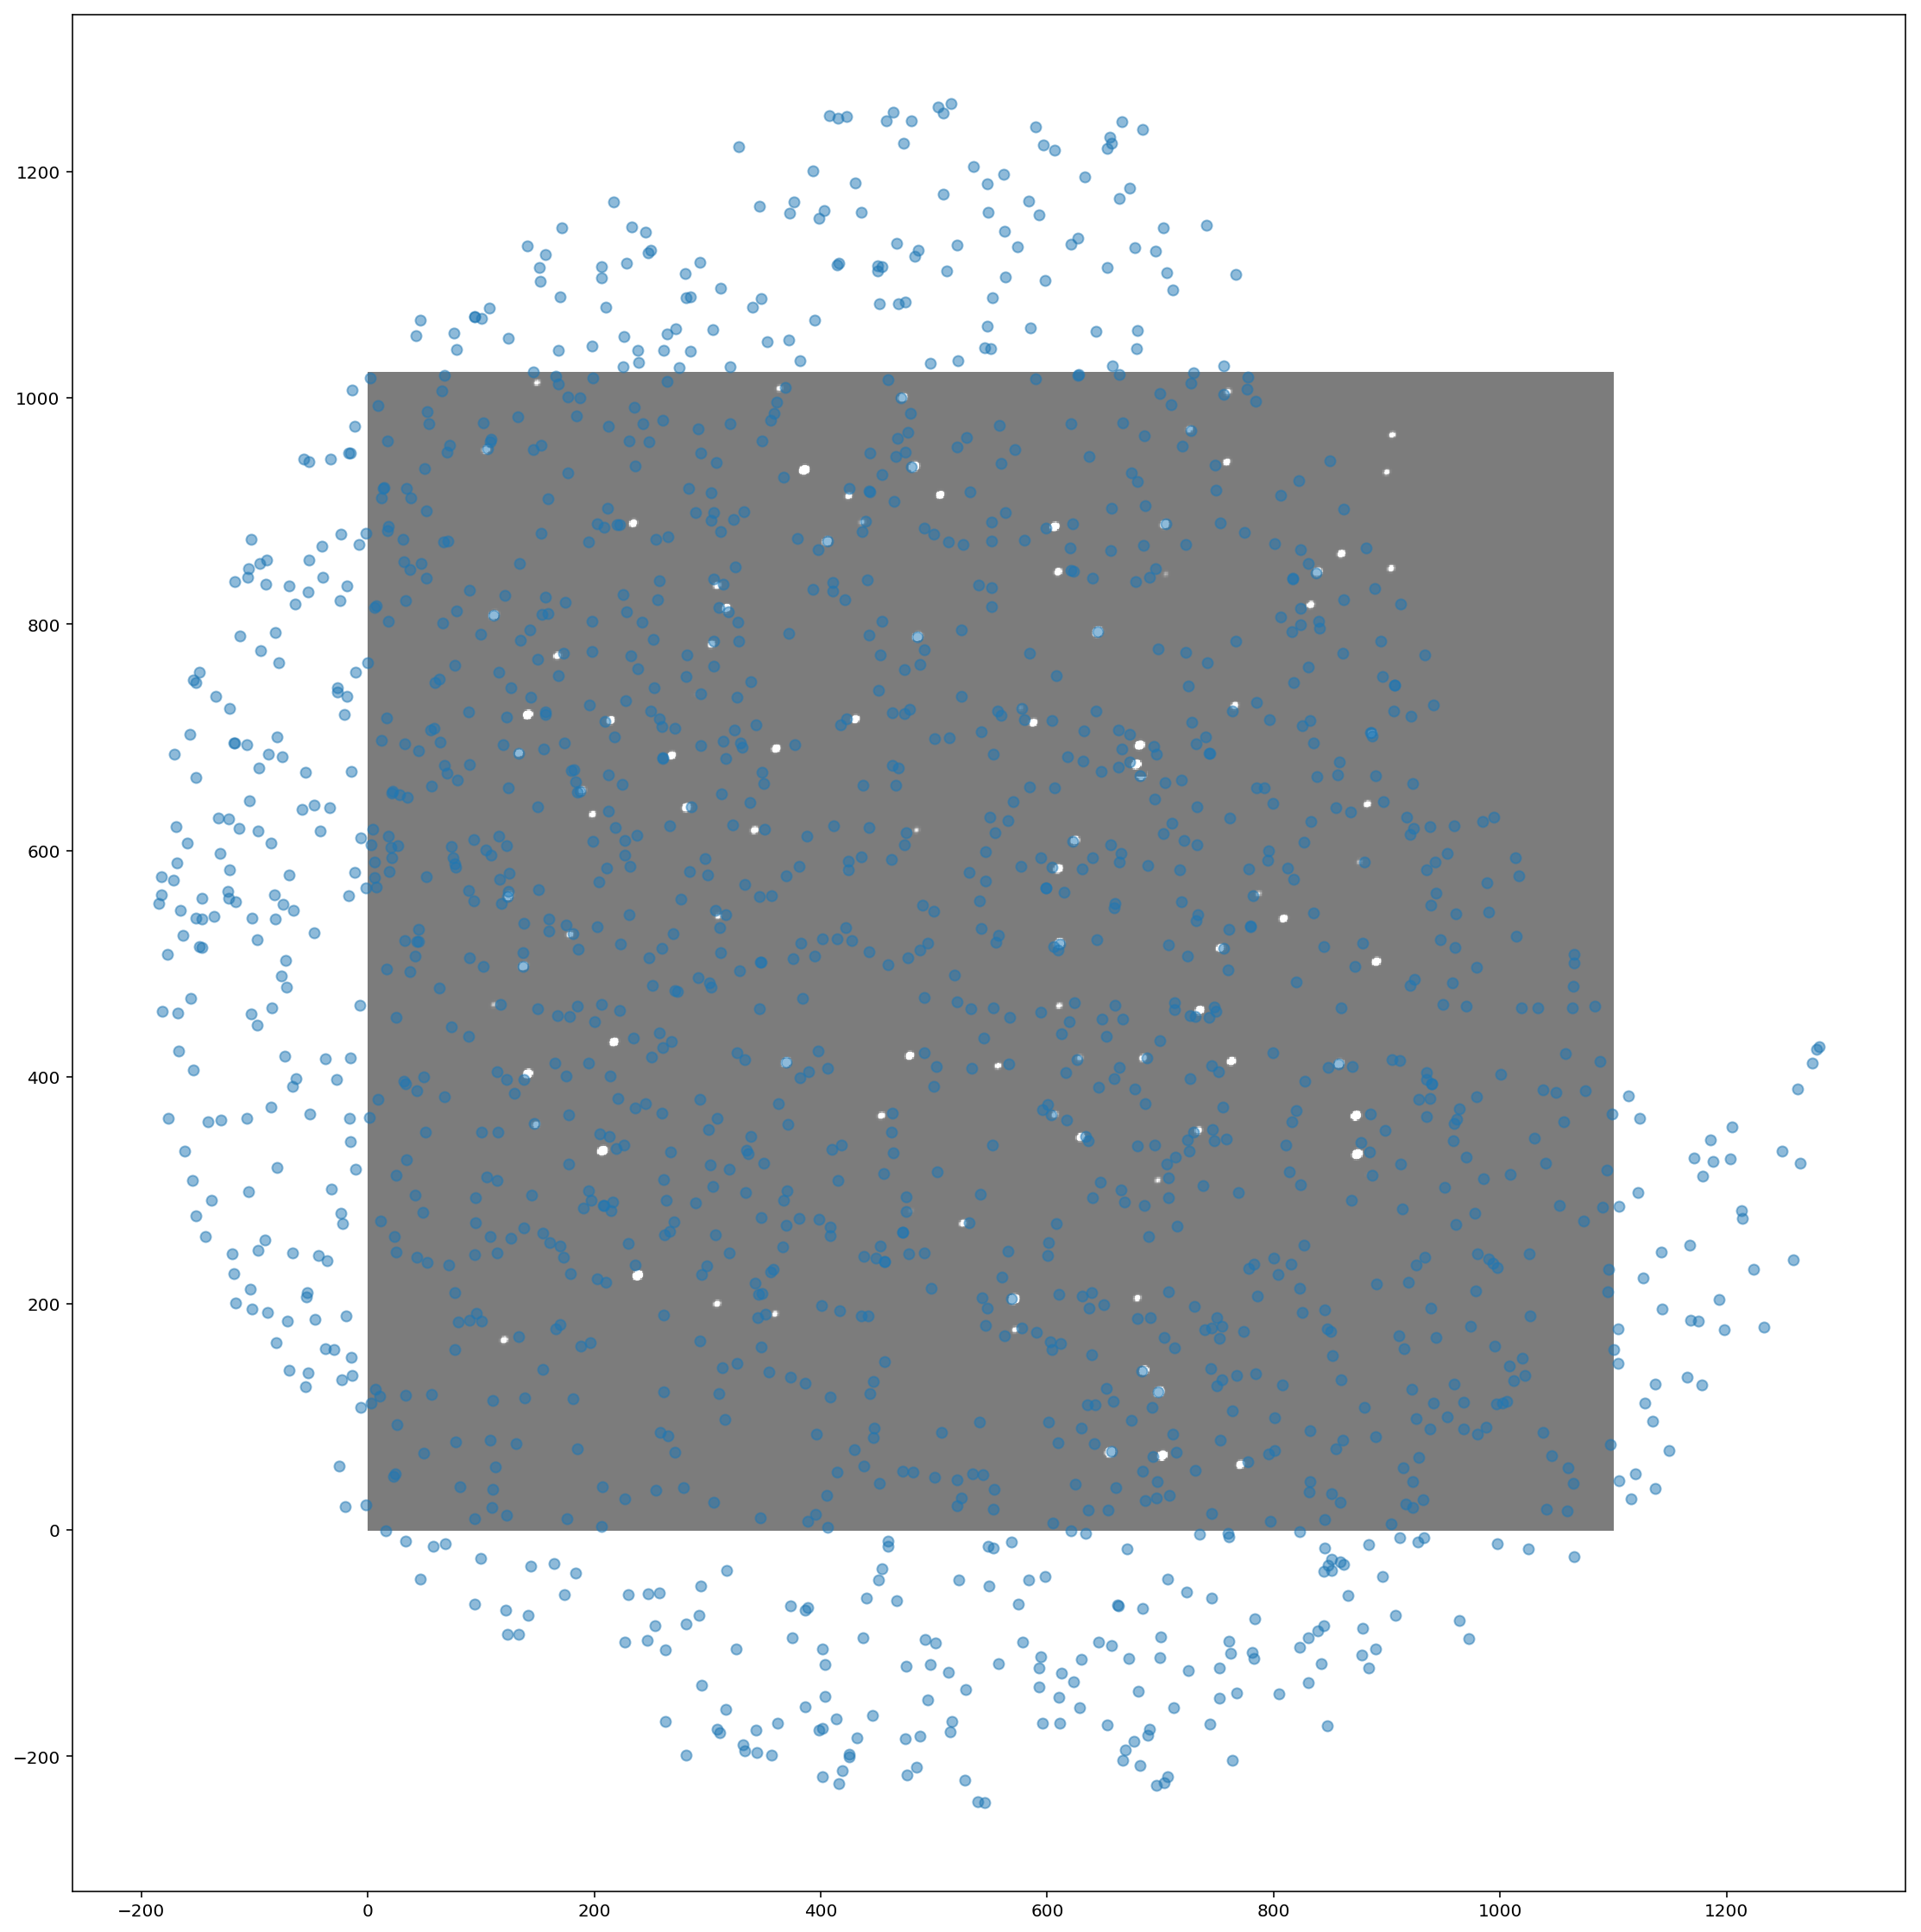

In [22]:
plt.figure(figsize=(20,20))

m, s = np.mean(hdu[0].data), np.std(hdu[0].data)
plt.imshow(hdu[0].data, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

plt.scatter(coords[:, 0], coords[:, 1], alpha=0.5)

Cool!

In [23]:
data, hdr0 = fitsio.read('../data/C17_driftscans/ffi-kacr2120/kplr2018131024020_ffi-orig.fits', ext=ch, header=True)

data = ffi_tools.preprocess_dFFI(data) 
sx, sy = data.shape

data_sub, bkg = ffi_tools.background_subtract(data, return_bkg=True)

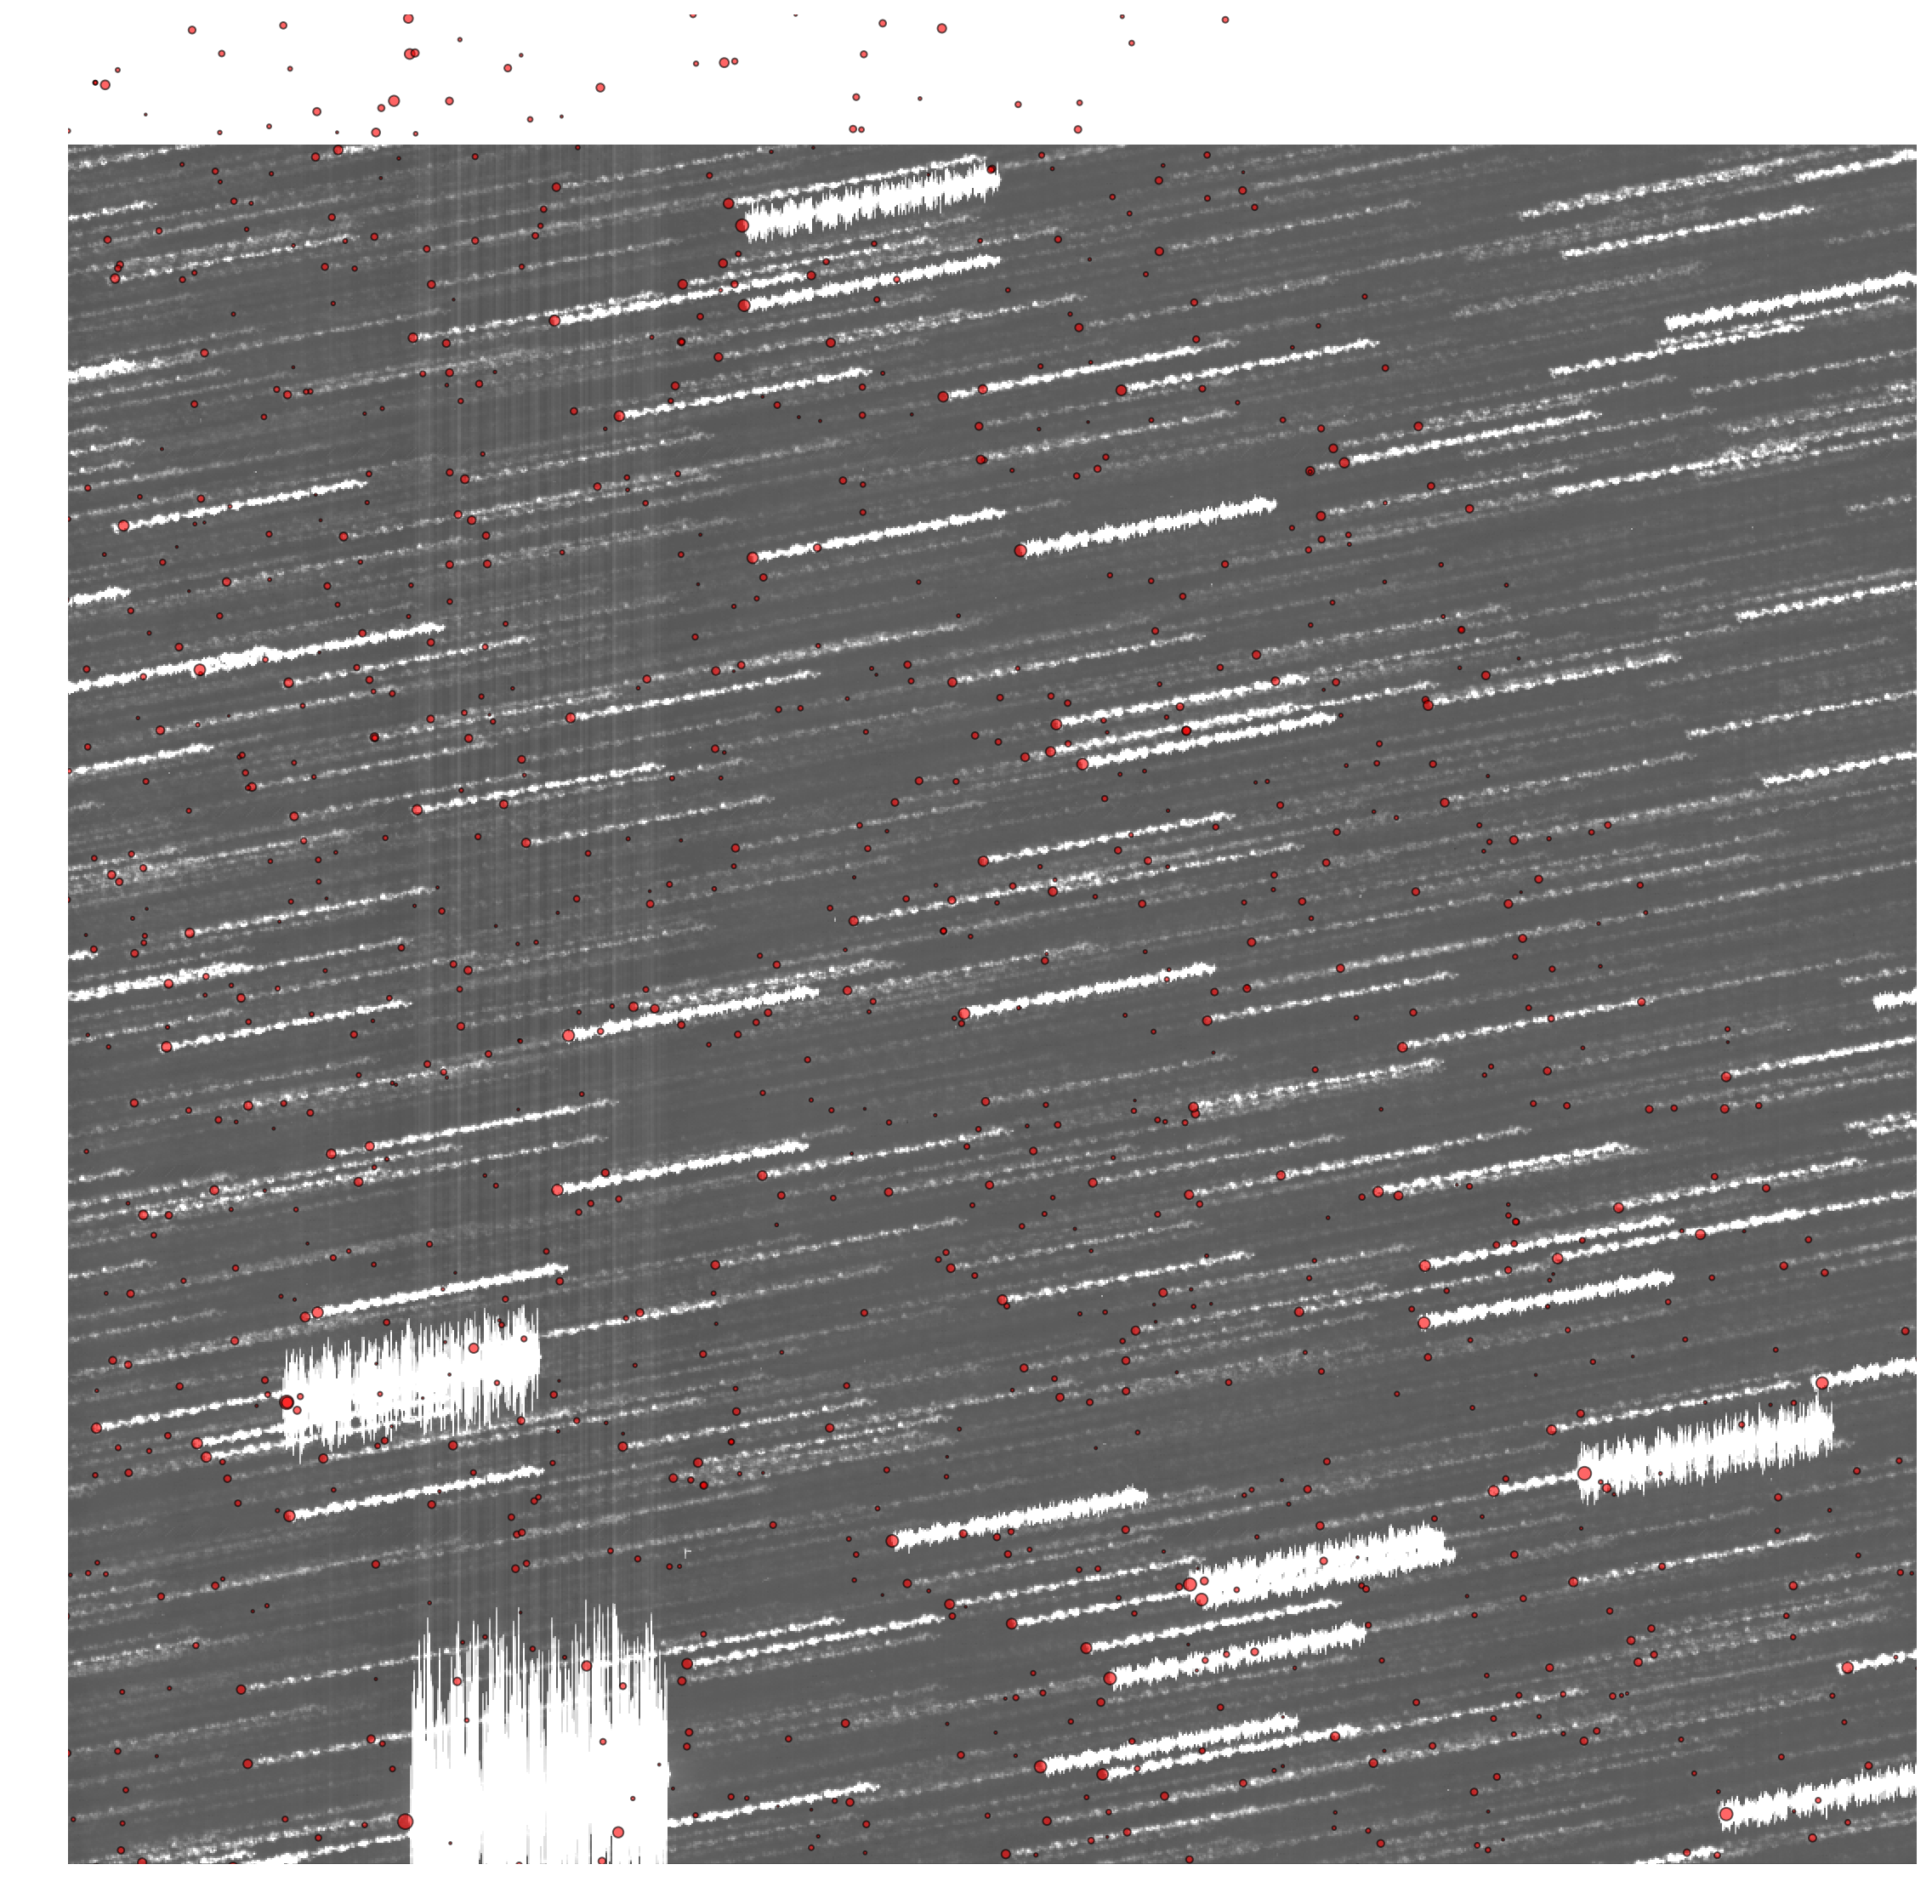

In [24]:
plt.figure(figsize=(20,20))

m, s = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ms = (np.log10(result['FG']) - 4.2) * 20
plt.scatter(coords[:, 0]-78, coords[:, 1]-12, s=ms, alpha=0.6, c='r', edgecolors='k')

plt.xlim(0, 1100)
plt.ylim(0, 1100)
plt.axis('off')
plt.savefig('../figures/ch37_dffi00_GaiaDR2_ids.png', bbox_inches='tight')

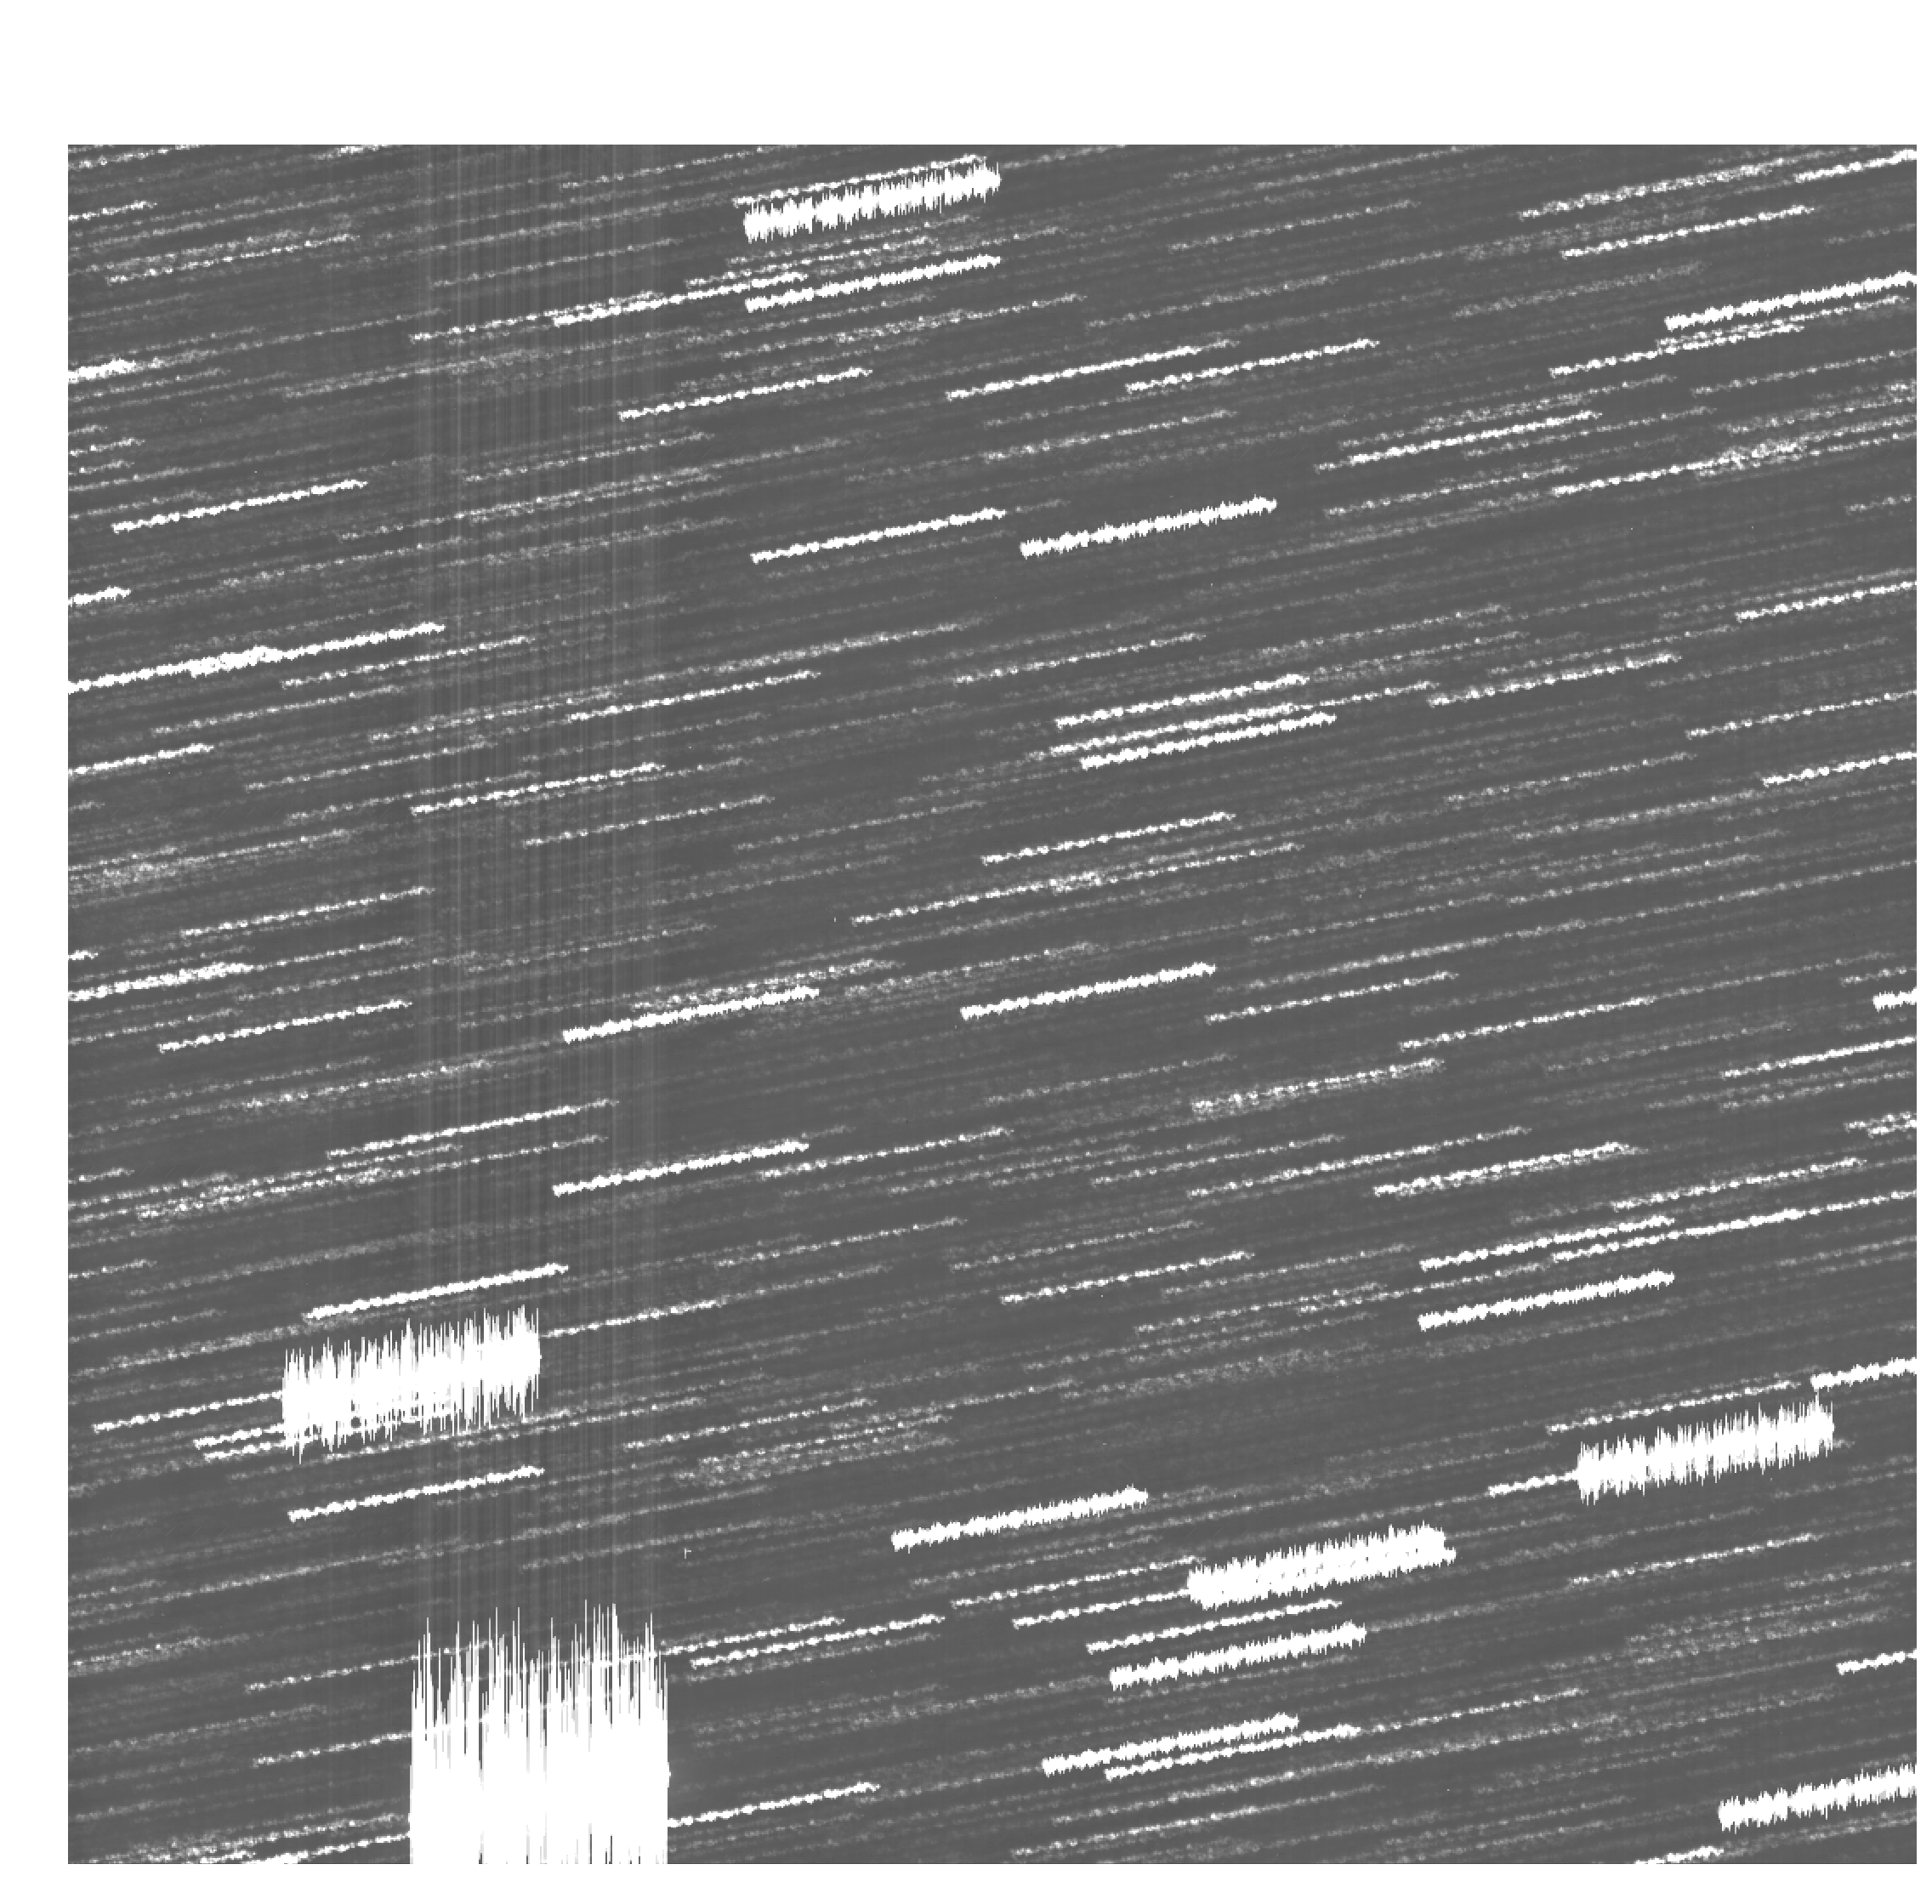

In [25]:
plt.figure(figsize=(20,20))

m, s = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ms = (np.log10(result['FG']) - 4.2) * 20
#plt.scatter(coords[:, 0]+74, coords[:, 1]+16, s=ms, alpha=0.6, c='r', edgecolors='k')

plt.xlim(0, 1100)
plt.ylim(0, 1100)
plt.axis('off')
plt.savefig('../figures/ch37_dffi00_GaiaDR2_end.png', bbox_inches='tight')

Awesome!  It's a match!

## Make a synthetic image

In [26]:
kernel = ffi_tools.get_kernel()

In [27]:
dw, dh = (np.array(kernel.shape)/2).astype(np.int)

In [28]:
dw, dh

(30, 87)

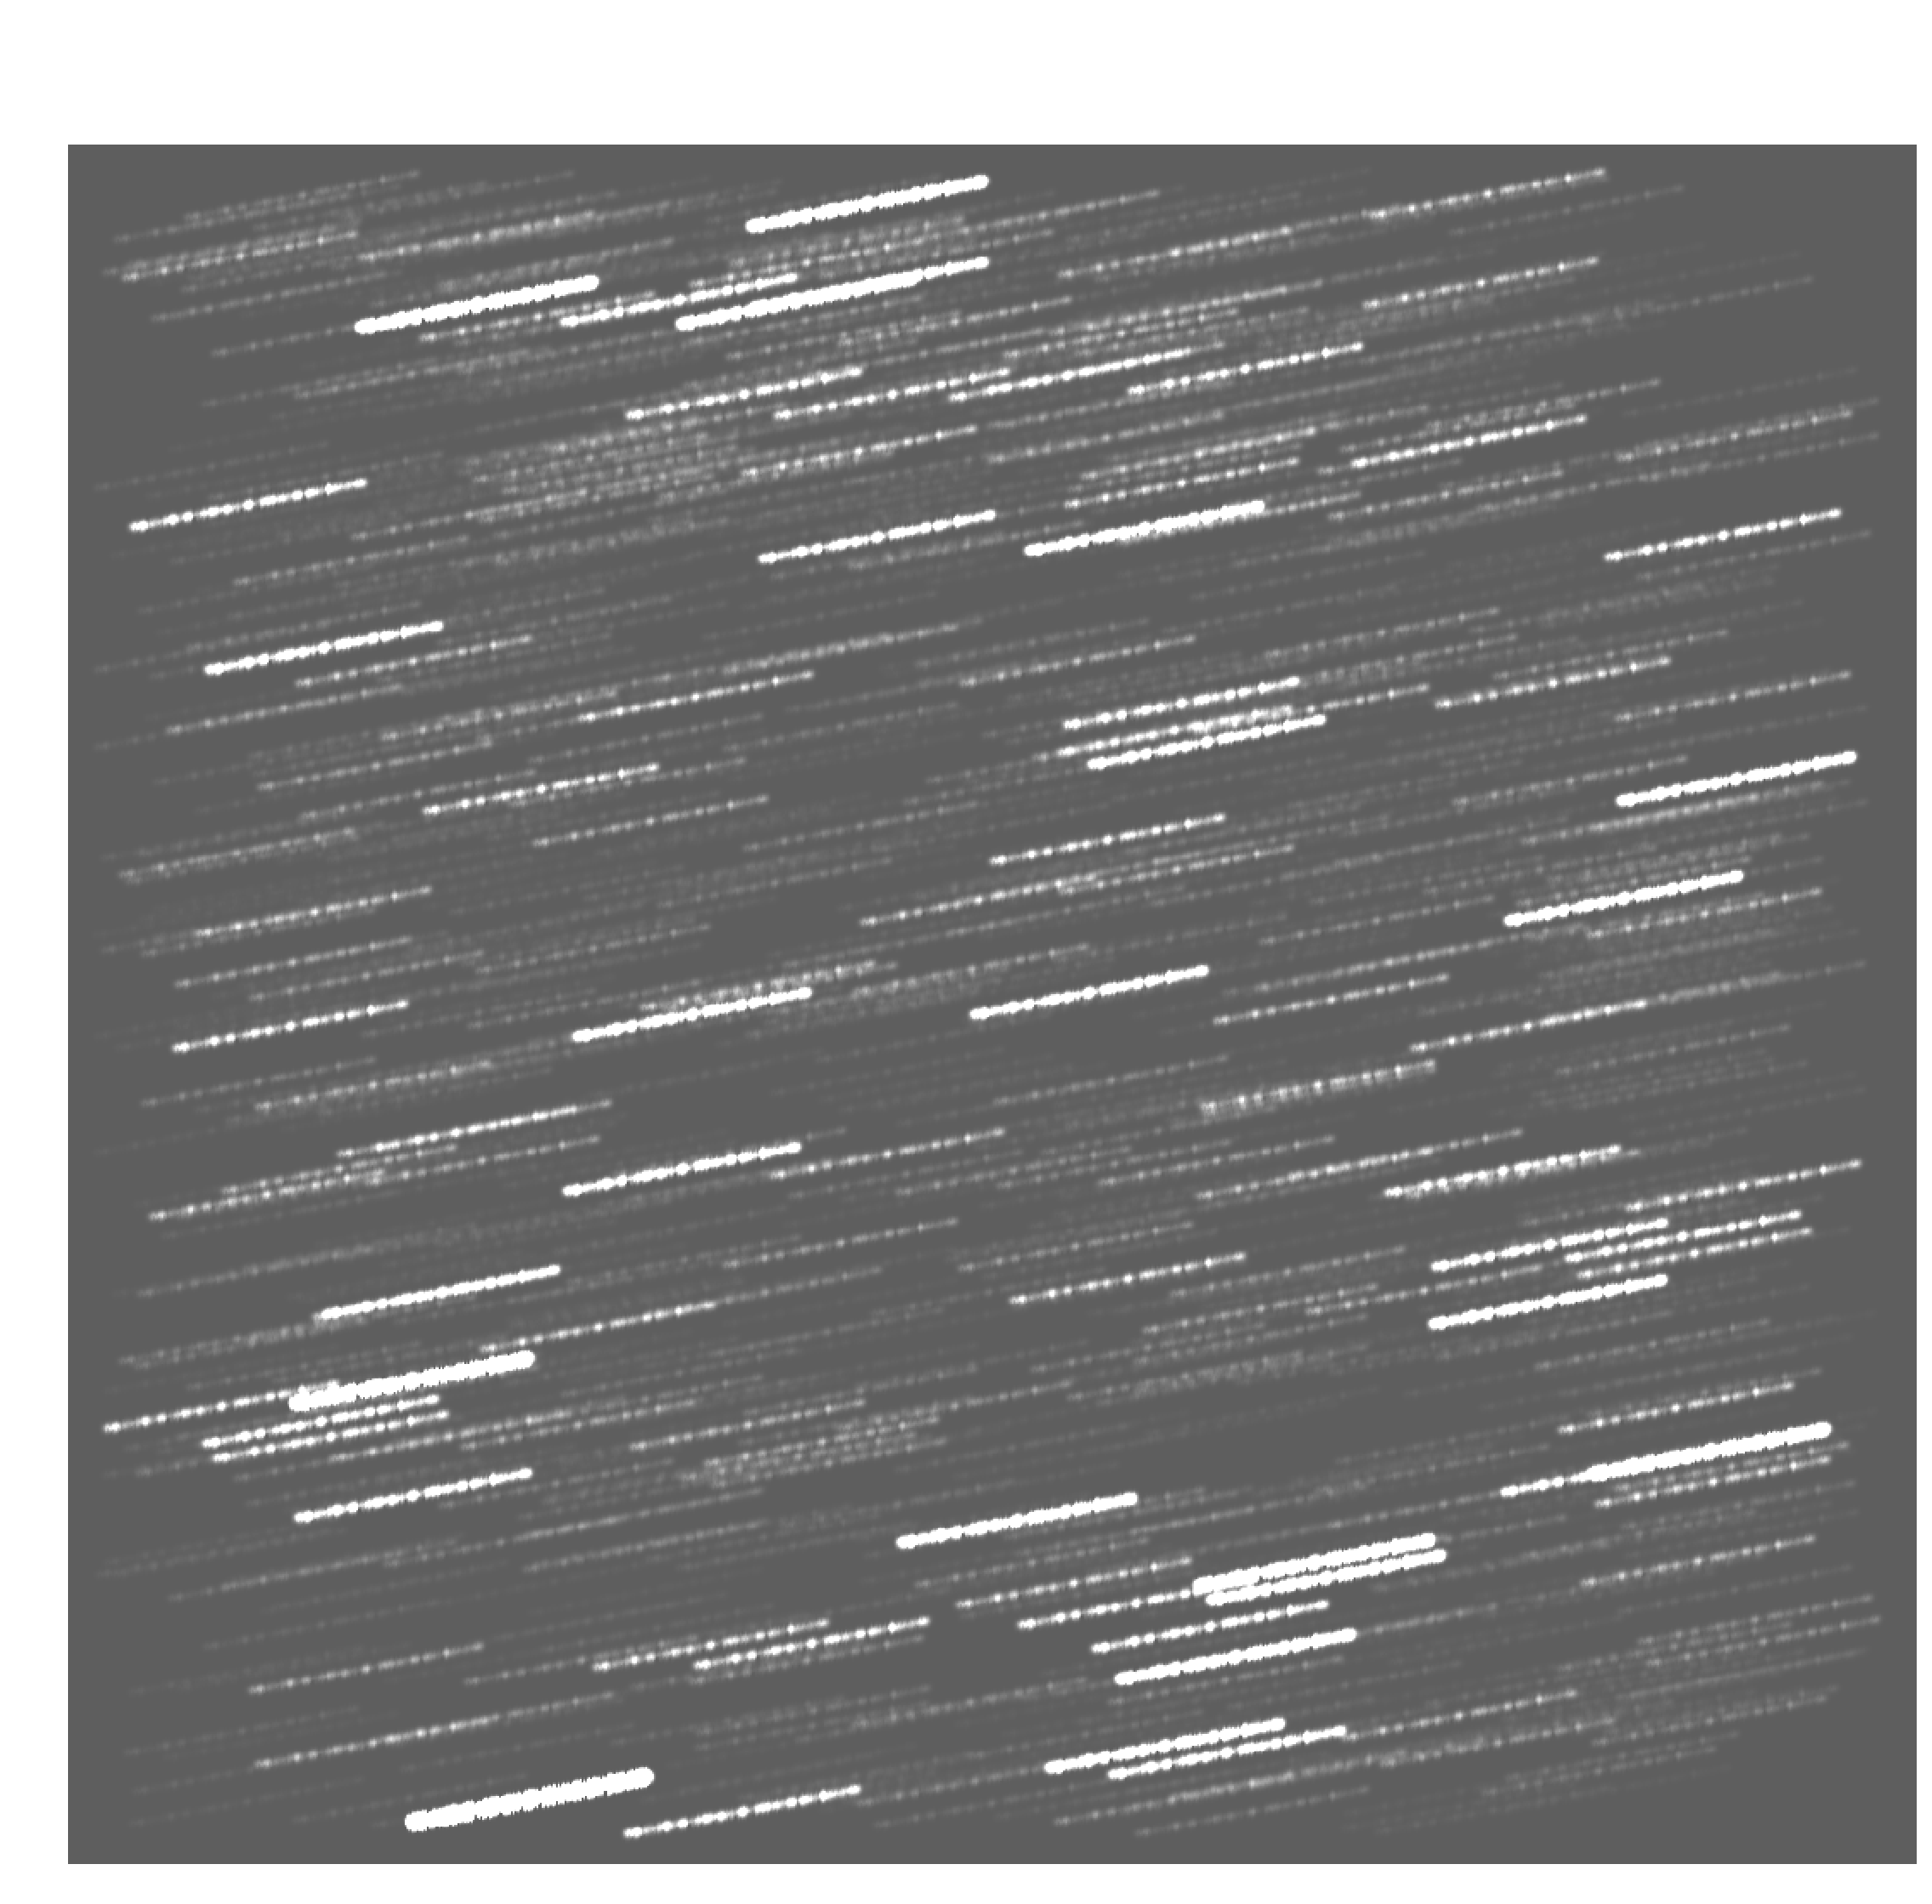

In [30]:
plt.figure(figsize=(20,20))

data_syn = data_sub*0.0

for i in range(len(result)):
    try:
        xc, yc, flx = int(coords[i, 1]), int(coords[i, 0]), result['FG'][i]
        data_syn[xc-dw:xc+dw, yc-dh:yc+dh+1] = data_syn[xc-dw:xc+dw, yc-dh:yc+dh+1] + kernel * flx / 15.0
    except:
        pass

m, s = np.mean(data_sub), np.std(data_sub)
plt.imshow(data_syn, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ms = (np.log10(result['FG']) - 4.2) * 20
#plt.scatter(coords[:, 0], coords[:, 1], s=ms, alpha=0.6, c='r', edgecolors='k')

plt.xlim(0, 1100)
plt.ylim(0, 1100)
plt.axis('off')
plt.savefig('../figures/ch37_dffi00_GaiaDR2_simulated.png', bbox_inches='tight')

Awesome!!!

### Difference image

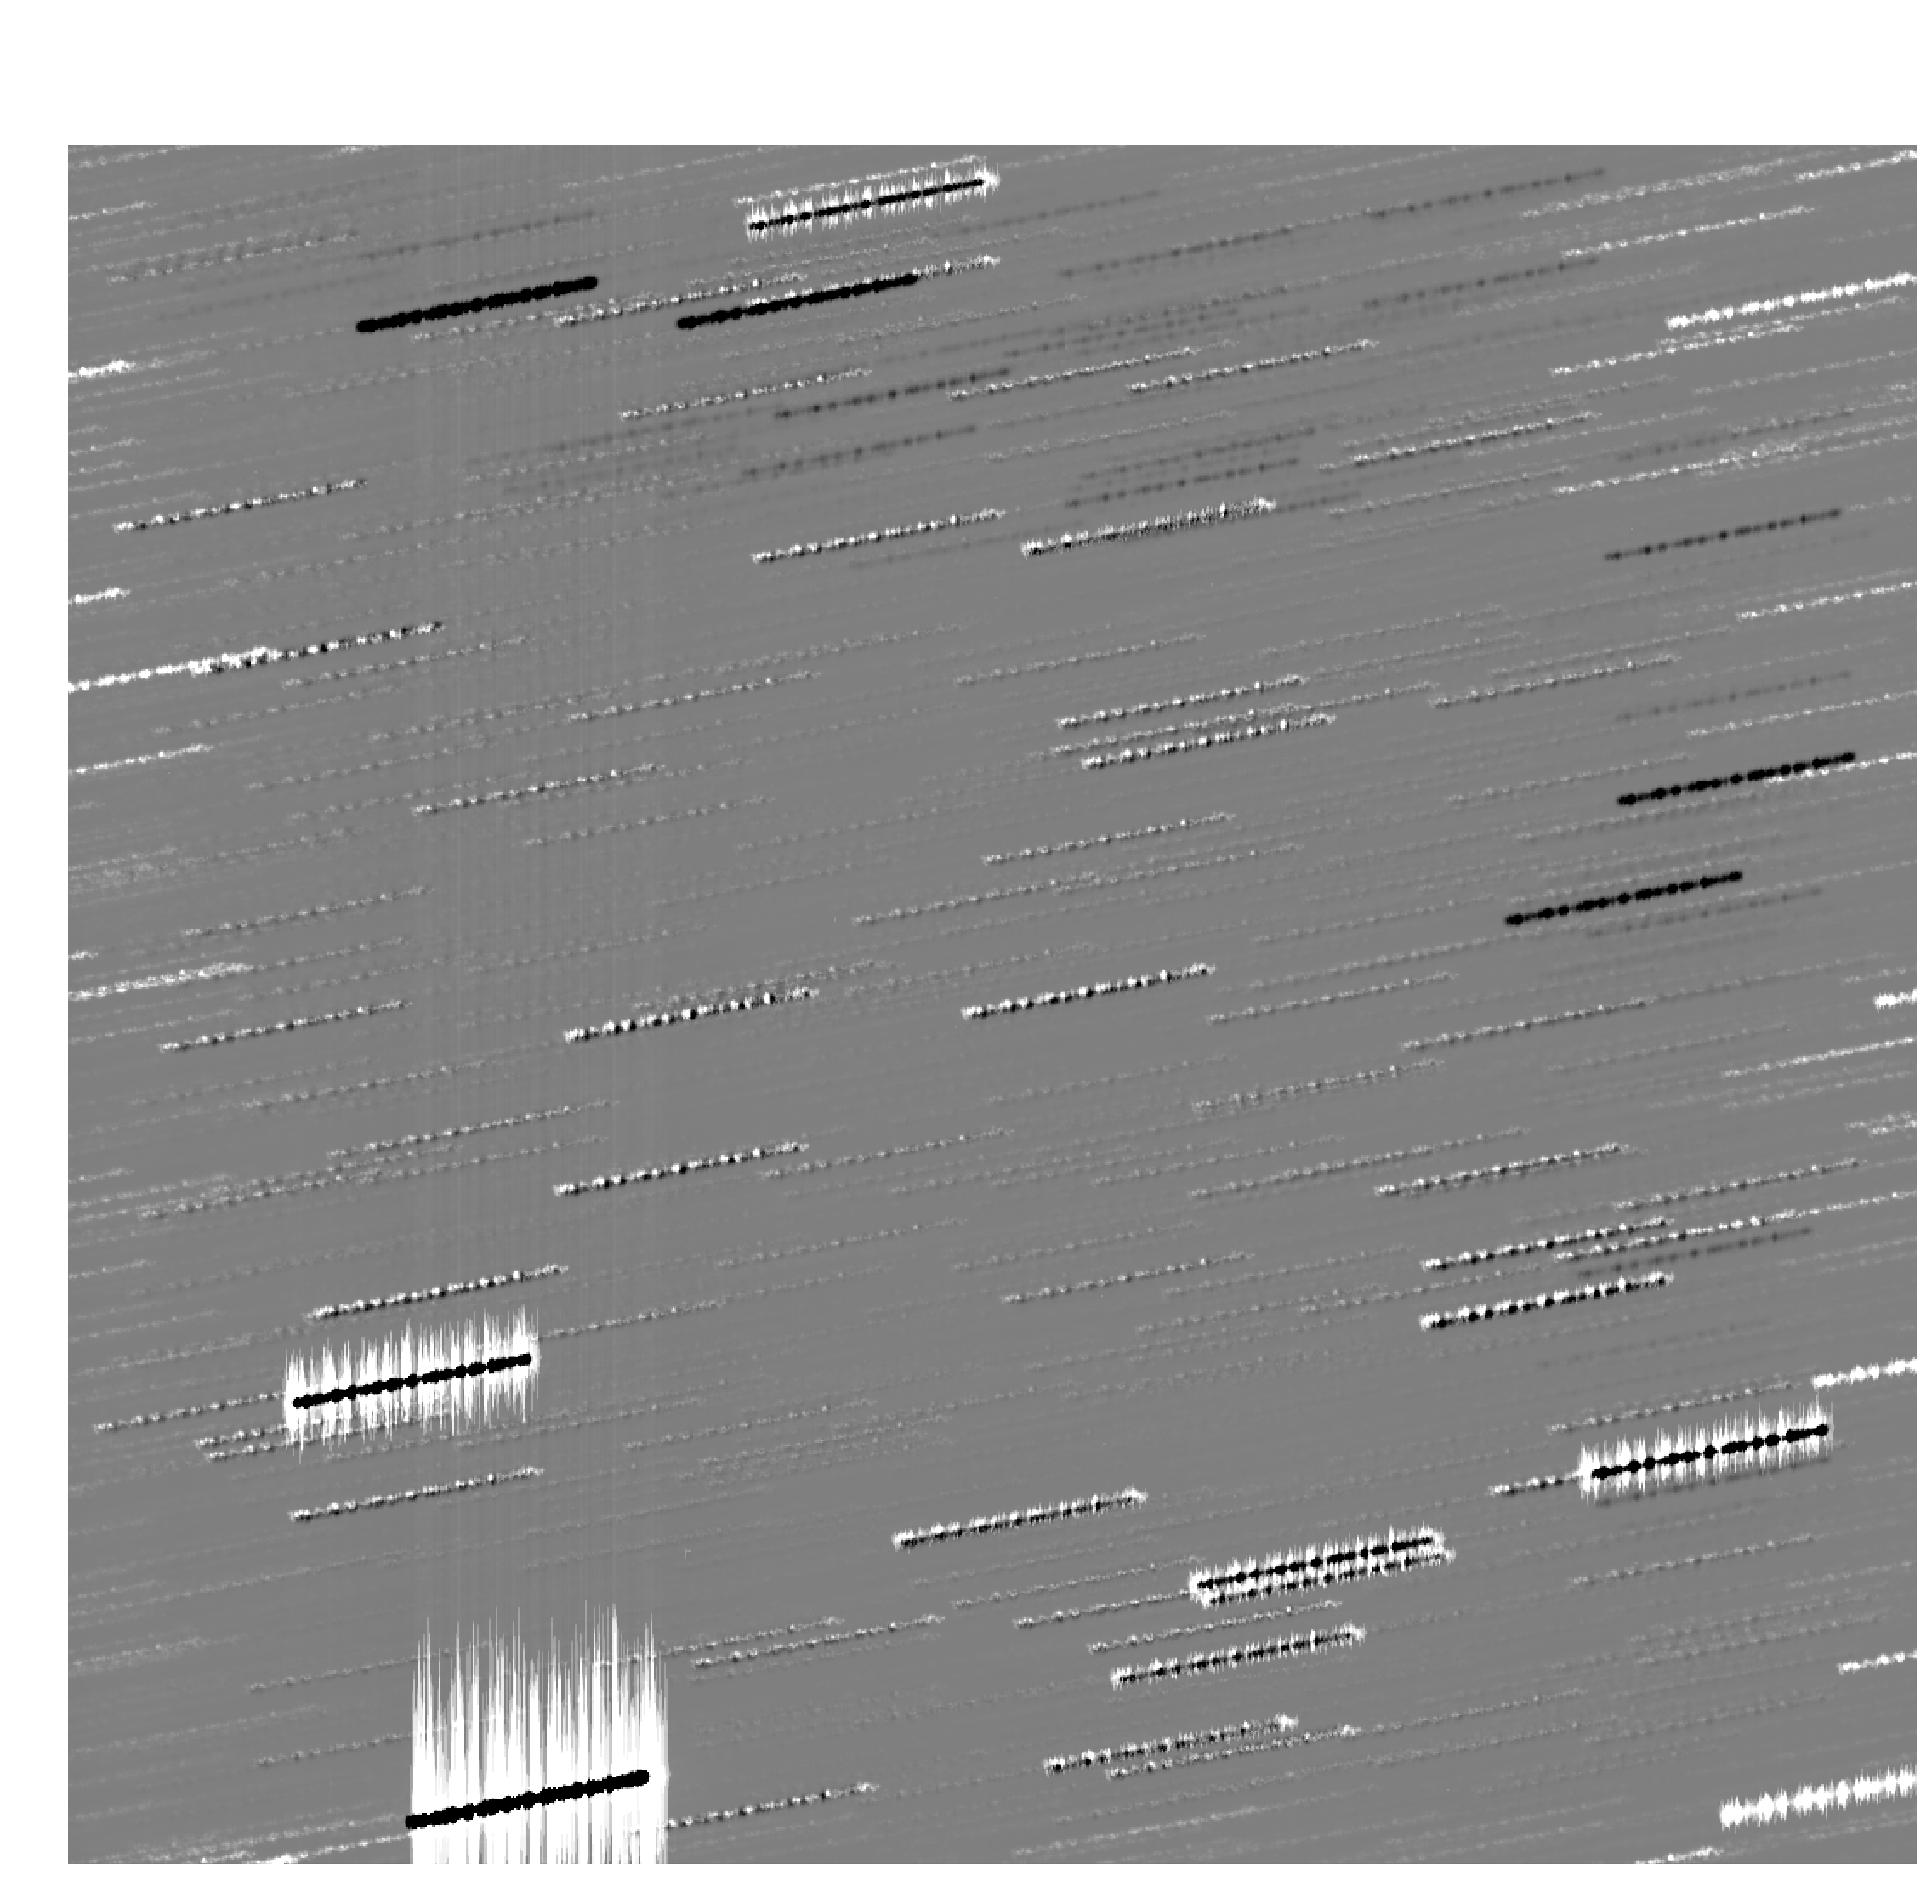

In [31]:
plt.figure(figsize=(20,20))

diff_image = data_sub - data_syn
m, s = np.mean(diff_image), np.std(diff_image)
plt.imshow(diff_image, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

ms = (np.log10(result['FG']) - 4.2) * 20
#plt.scatter(coords[:, 0], coords[:, 1], s=ms, alpha=0.6, c='r', edgecolors='k')

plt.xlim(0, 1100)
plt.ylim(0, 1100)
plt.axis('off')
plt.savefig('../figures/ch37_dffi00_GaiaDR2_diff.png', bbox_inches='tight')

The end for now

In [32]:
#! open ../figures/